In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sb

#### hyperparameter tuning of the RF model

In [2]:
df = pd.read_csv('DNS_datastore.csv', index_col=0)

features = list(df.columns)[11:]

x = np.array(df.loc[:,features].fillna(0))
y = np.array(df['Label'])

In [3]:
mu = 0
sigma = (0.03 * x.mean(axis=0))
noise = np.random.normal(mu, sigma, size=x.shape)

x = x + noise

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [5]:
def cm(rf, x, y):
    y_predict = rf.predict(x)
    cm = confusion_matrix(y, y_predict)
    names = ['TN','FP','FN','TP']
    #counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percents = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v3}' for v1, v3 in zip(names, percents)]
    labels = np.asarray(labels).reshape(2,2)
    plt.title('Confusion Matrix')
    fig = sb.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False).get_figure()

    TN, FP, FN, TP =  [int(x) for x in np.asarray(cm).reshape(-1)]
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    metrics = pd.DataFrame(columns=['Evaluation Metric (other names)','Equation','Value'])
    metrics.loc['Accuracy',:] = ['', 'TN+TP / total', '%.2f%%' %((TN+TP)/(TN+TP+FN+FP)*100)]
    metrics.loc['True Positive Rate',:] = ['Sensitivity, Recall', 'TP/(TP+FN)', '%.2f%%' %(recall*100)]
    metrics.loc['True Negative Rate',:] = ['Specificity', 'TN/(TN+FN)', '%.2f%%' %(TN/(TN+FN)*100)]
    metrics.loc['False Positive Rate',:] = ['Fall-Out', 'FP/(TN+FN)', '%.2f%%' %(FP/(TN+FN)*100)]
    metrics.loc['False Negative Rate',:] = ['Miss Rate', 'TN/(FN+TP)', '%.2f%%' %(FN/(FN+TP)*100)]
    metrics.loc['Positive Predictive Value',:] = ['Precision', 'TP/(TP+FP)', '%.2f%%' %(precision*100)]
    metrics.loc['False Discovery Rate',:] = ['', 'FP/(FP+TP)', '%.2f%%' %(FP/(FP+TP)*100)]
    metrics.loc['F-1 Score',:] = ['', '2*(Recall*Precision) /(Recall+Precision)', \
                                  '%.2f%%' %(2*(recall*precision)/(recall+precision)*100)]
    display(metrics)
    return (TN+TP)/(TN+TP+FN+FP)*100

In [6]:
%%time
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_features': ['sqrt', 'log2'] + list(np.linspace(0,1,11)),
    'max_depth': list(range(2,6)),
    'max_features': list(range(2,15)),
    'min_samples_leaf': list(np.linspace(0,1,11)),
    'min_samples_split': list(np.linspace(0,1,11)),
    'n_estimators': list(range(2,15))
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 81796 candidates, totalling 245388 fits


C:\Users\dewie\anaconda3\envs\ml-env\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  category=UserWarning


Wall time: 1h 12min 12s


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [2, 3, 4, 5],
                         'max_features': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14],
                         'min_samples_leaf': [0.0, 0.1, 0.2,
                                              0.30000000000000004, 0.4, 0.5,
                                              0.6000000000000001,
                                              0.7000000000000001, 0.8, 0.9,
                                              1.0],
                         'min_samples_split': [0.0, 0.1, 0.2,
                                               0.30000000000000004, 0.4, 0.5,
                                               0.6000000000000001,
                                               0.7000000000000001, 0.8, 0.9,
                                               1.0],
                         'n_estimators': [2, 3, 4, 5, 6, 7, 8, 

<bound method BaseEstimator.get_params of RandomForestClassifier()>


,Evaluation Metric (other names),Equation,Value
Accuracy,,TN+TP / total,100.00%
True Positive Rate,"Sensitivity, Recall",TP/(TP+FN),100.00%
True Negative Rate,Specificity,TN/(TN+FN),100.00%
False Positive Rate,Fall-Out,FP/(TN+FN),0.00%
False Negative Rate,Miss Rate,TN/(FN+TP),0.00%
Positive Predictive Value,Precision,TP/(TP+FP),100.00%
False Discovery Rate,,FP/(FP+TP),0.00%
F-1 Score,,2*(Recall*Precision) /(Recall+Precision),100.00%


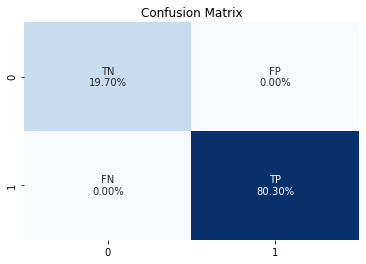

In [16]:
base_rf = RandomForestClassifier()
pprint(base_rf.get_params)
base_rf.fit(x_train, y_train)
base_accuracy = cm(base_rf, x_test, y_test)

{'bootstrap': True,
 'max_depth': 3,
 'max_features': 5,
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.2,
 'n_estimators': 11}


,Evaluation Metric (other names),Equation,Value
Accuracy,,TN+TP / total,99.87%
True Positive Rate,"Sensitivity, Recall",TP/(TP+FN),99.88%
True Negative Rate,Specificity,TN/(TN+FN),99.53%
False Positive Rate,Fall-Out,FP/(TN+FN),0.20%
False Negative Rate,Miss Rate,TN/(FN+TP),0.12%
Positive Predictive Value,Precision,TP/(TP+FP),99.95%
False Discovery Rate,,FP/(FP+TP),0.05%
F-1 Score,,2*(Recall*Precision) /(Recall+Precision),99.92%


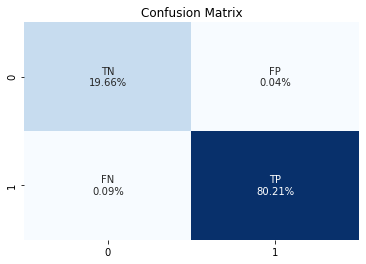

In [17]:
pprint(grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = cm(best_grid, x_test, y_test)

In [31]:
def plot_results(model, param = 'n_estimators', name = 'Number of Trees'):
    param_name = 'param_%s' % param

    # Extract information from the cross validation model
    #train_scores = model.cv_results_['mean_train_score']
    test_scores = model.cv_results_['mean_test_score']
    train_time = model.cv_results_['mean_fit_time']
    param_values = list(model.cv_results_[param_name])
    
    # Plot the scores over the parameter
    plt.subplots(1, 2, figsize=(10, 6))
    plt.subplot(121)
    #plt.plot(param_values, train_scores, 'bo-', label = 'train')
    plt.plot(param_values, test_scores, 'go-', label = 'test')
    plt.ylim(ymin = 0.9, ymax = 1)
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('Accuracy')
    plt.title('Score vs %s' % name)
    
    plt.subplot(122)
    plt.plot(param_values, train_time, 'ro-')
    plt.ylim(ymin = 0.0, ymax = 2.0)
    plt.xlabel(name)
    plt.ylabel('Train Time (sec)')
    plt.title('Training Time vs %s' % name)
    
    
    plt.tight_layout(pad = 4)

Fitting 3 folds for each of 49 candidates, totalling 147 fits


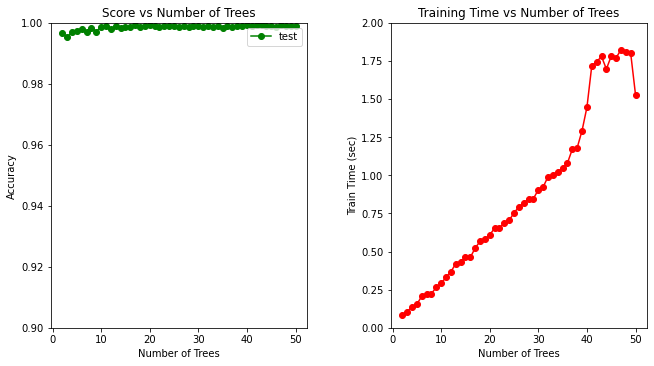

In [32]:
# Grid with only the number of trees changed
tree_grid = {'n_estimators': list(range(2,51))}

# Create the grid search model and fit to the training data
tree_grid_search = GridSearchCV(best_grid, param_grid=tree_grid, verbose = 2, n_jobs=-1, cv = 3, scoring = 'accuracy')
tree_grid_search.fit(x_train, y_train)

plot_results(tree_grid_search)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


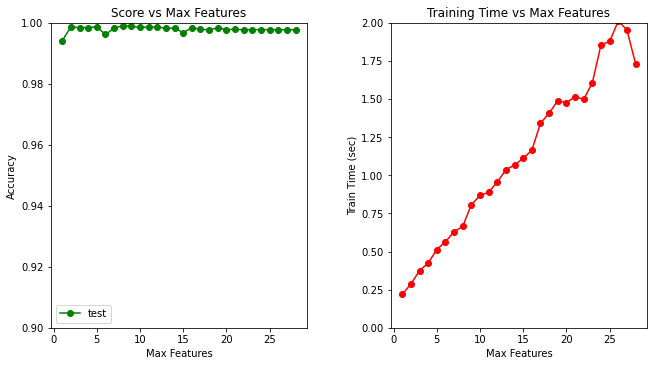

In [40]:
feature_grid = {'max_features': list(range(1, x_train.shape[1] + 1))}

feature_grid_search = GridSearchCV(best_grid, param_grid=feature_grid, cv = 3, n_jobs=-1, verbose= 2, scoring = 'accuracy')
feature_grid_search.fit(x_train, y_train)

plot_results(feature_grid_search, param='max_features', name = 'Max Features')

#### feature selection

In [9]:
sel = SelectFromModel(best_grid)
sel.fit(x_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(max_depth=3, max_features=5,
                                                 min_samples_leaf=0.1,
                                                 min_samples_split=0.2,
                                                 n_estimators=11))

In [10]:
selected_feat= df.loc[:,features].columns[(sel.get_support())]
print(selected_feat)

Index(['Subdomain Entropy', 'Payload Entropy', 'longest word Subdomain',
       'Numeric Count', 'Subdomain Character Count', 'Subdomain Numeric Count',
       'Payload Lowercase Count', 'Payload Special Char Count',
       'Avg Subdomain Length (Session)'],
      dtype='object')


<AxesSubplot:>

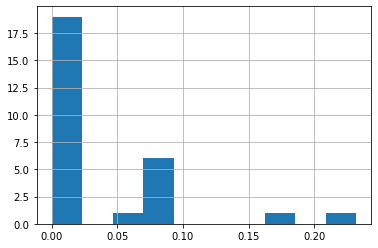

In [11]:
pd.Series(sel.estimator_.feature_importances_.ravel()).hist()

#### compare to DT/SVM/KNN

,Evaluation Metric (other names),Equation,Value
Accuracy,,TN+TP / total,99.93%
True Positive Rate,"Sensitivity, Recall",TP/(TP+FN),99.98%
True Negative Rate,Specificity,TN/(TN+FN),99.93%
False Positive Rate,Fall-Out,FP/(TN+FN),0.27%
False Negative Rate,Miss Rate,TN/(FN+TP),0.02%
Positive Predictive Value,Precision,TP/(TP+FP),99.93%
False Discovery Rate,,FP/(FP+TP),0.07%
F-1 Score,,2*(Recall*Precision) /(Recall+Precision),99.96%


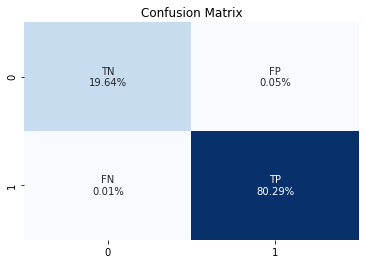

In [37]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
dt_accuracy = cm(dt, x_test, y_test)

,Evaluation Metric (other names),Equation,Value
Accuracy,,TN+TP / total,99.93%
True Positive Rate,"Sensitivity, Recall",TP/(TP+FN),99.98%
True Negative Rate,Specificity,TN/(TN+FN),99.93%
False Positive Rate,Fall-Out,FP/(TN+FN),0.27%
False Negative Rate,Miss Rate,TN/(FN+TP),0.02%
Positive Predictive Value,Precision,TP/(TP+FP),99.93%
False Discovery Rate,,FP/(FP+TP),0.07%
F-1 Score,,2*(Recall*Precision) /(Recall+Precision),99.96%


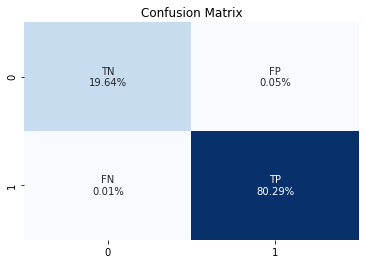

In [38]:
from sklearn import svm
svm = svm.SVC()
svm.fit(x_train, y_train)
svm_accuracy = cm(dt, x_test, y_test)

,Evaluation Metric (other names),Equation,Value
Accuracy,,TN+TP / total,99.95%
True Positive Rate,"Sensitivity, Recall",TP/(TP+FN),99.97%
True Negative Rate,Specificity,TN/(TN+FN),99.86%
False Positive Rate,Fall-Out,FP/(TN+FN),0.14%
False Negative Rate,Miss Rate,TN/(FN+TP),0.03%
Positive Predictive Value,Precision,TP/(TP+FP),99.97%
False Discovery Rate,,FP/(FP+TP),0.03%
F-1 Score,,2*(Recall*Precision) /(Recall+Precision),99.97%


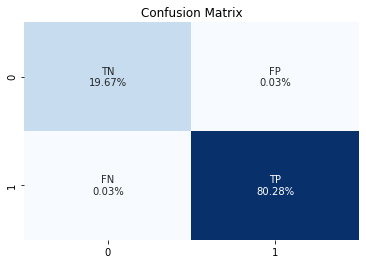

In [39]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(x_train, y_train)
neigh_accuracy = cm(neigh, x_test, y_test)